In [1]:
import pandas as pd
import os
import shutil
# !pip install split-folders

### Display Sample Glaucoma and Normal Fundus Images

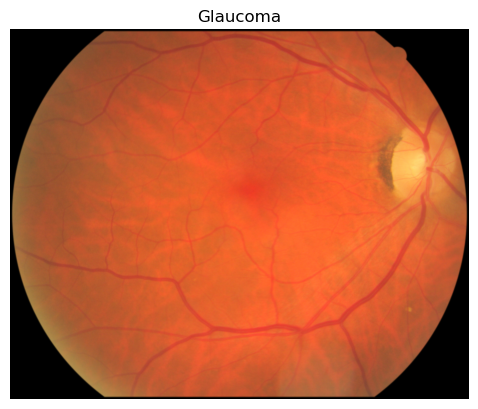

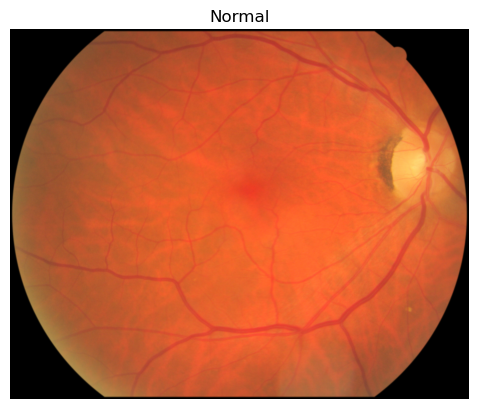

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
g_img="D:/Project/Datasets/Glaucoma-detection/Images_Combined/glaucoma_positive/image_18.jpg"
img_glaucoma=mpimg.imread(g_img)
plt.imshow(img_glaucoma)
plt.title('Glaucoma')
plt.axis('off')
plt.show()

n_img="D:/Project/Datasets/Glaucoma-detection/Images_Combined/glaucoma_negative/007.jpg"
img_normal=mpimg.imread(g_img)
plt.imshow(img_normal)
plt.title('Normal')
plt.axis('off')
plt.show()

In [3]:
print(len(os.listdir("D:/Project/Datasets/Glaucoma-detection/Glaucoma Classification Datasets/glaucoma_combined/Glaucoma")),len(os.listdir("D:/Project/Datasets/Glaucoma-detection/Glaucoma Classification Datasets/glaucoma_combined/Normal")))

638 653


In [7]:
import splitfolders
import pathlib

base_dir="D:/Project/Datasets/Glaucoma-detection/Glaucoma Classification Datasets/glaucoma_combined"
base_dir=pathlib.Path(base_dir)
img_height=256
img_width=256
batch_size=32
output_path="D:/Project/Datasets/Glaucoma-detection/Glaucoma Classification Datasets/glaucoma_combined"

splitfolders.ratio(base_dir,output=output_path,seed=1337,ratio=(.8,.1,.1),group_prefix=None)

Copying files: 1291 files [00:07, 172.39 files/s]


510 522


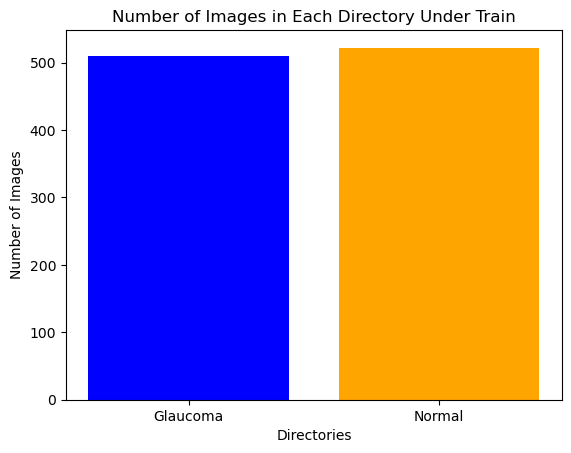

63 65


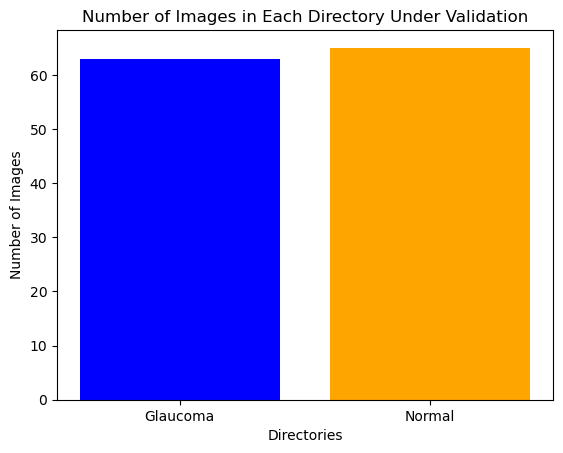

65 66


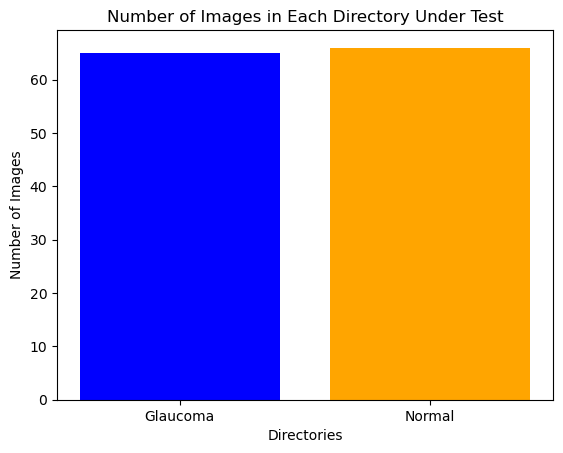

In [8]:
dir1="D:/Project/Datasets/Glaucoma-detection/Glaucoma Classification Datasets/glaucoma_combined/train/Glaucoma"
dir2="D:/Project/Datasets/Glaucoma-detection/Glaucoma Classification Datasets/glaucoma_combined/train/Normal"

count1=len(os.listdir(dir1))
count2=len(os.listdir(dir2))

print(count1,count2)

directories=['Glaucoma','Normal']
counts=[count1,count2]

plt.bar(directories, counts, color=['blue', 'orange'])
plt.xlabel('Directories')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Directory Under Train')
plt.show()

dir3="D:/Project/Datasets/Glaucoma-detection/Glaucoma Classification Datasets/glaucoma_combined/val/Glaucoma"
dir4="D:/Project/Datasets/Glaucoma-detection/Glaucoma Classification Datasets/glaucoma_combined/val/Normal"

count3=len(os.listdir(dir3))
count4=len(os.listdir(dir4))

print(count3,count4)

directories=['Glaucoma','Normal']
counts=[count3,count4]

plt.bar(directories, counts, color=['blue', 'orange'])
plt.xlabel('Directories')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Directory Under Validation')
plt.show()

dir5="D:/Project/Datasets/Glaucoma-detection/Glaucoma Classification Datasets/glaucoma_combined/test/Glaucoma"
dir6="D:/Project/Datasets/Glaucoma-detection/Glaucoma Classification Datasets/glaucoma_combined/test/Normal"

count5=len(os.listdir(dir5))
count6=len(os.listdir(dir6))

print(count5,count6)

directories=['Glaucoma','Normal']
counts=[count5,count6]

plt.bar(directories, counts, color=['blue', 'orange'])
plt.xlabel('Directories')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Directory Under Test')
plt.show()

In [5]:
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout,Input,Lambda, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from skimage import exposure, filters
from skimage.restoration import denoise_tv_chambolle
from keras.optimizers import Adam
from keras import regularizers
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [6]:
train_dir="D:/Project/Datasets/Glaucoma-detection/Glaucoma Classification Datasets/glaucoma_combined/train"
val_dir="D:/Project/Datasets/Glaucoma-detection/Glaucoma Classification Datasets/glaucoma_combined/val"
test_dir="D:/Project/Datasets/Glaucoma-detection/Glaucoma Classification Datasets/glaucoma_combined/test"
img_size=(256,256)
batch_size=32

In [7]:
data_gen=ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.15,
                            zoom_range=0.15,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_generator=data_gen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
)

validation_generator = data_gen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
)

test_generator = data_gen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
)

Found 1032 images belonging to 2 classes.
Found 128 images belonging to 2 classes.
Found 131 images belonging to 2 classes.


In [8]:
train_generator.class_indices

{'Glaucoma': 0, 'Normal': 1}

In [10]:
model=Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(256,256,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(2, activation='sigmoid'))

In [11]:
optimizer = tf.keras.optimizers.legacy.Adam()
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 batch_normalization_4 (Bat  (None, 127, 127, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                      

In [14]:
history = model.fit(
    train_generator,
    steps_per_epoch=int(round(1032/32)),
    epochs=150,
    validation_data=validation_generator,
    validation_steps=int(round(128/32))
)

Epoch 1/150
32/32 [==============================] - 66s 2s/step - loss: 11.1876 - accuracy: 0.6890 - val_loss: 9.8333 - val_accuracy: 0.4922
Epoch 2/150
32/32 [==============================] - 59s 2s/step - loss: 9.9812 - accuracy: 0.7350 - val_loss: 7.9254 - val_accuracy: 0.5078
Epoch 3/150
32/32 [==============================] - 60s 2s/step - loss: 7.8419 - accuracy: 0.7420 - val_loss: 7.7150 - val_accuracy: 0.4922
Epoch 4/150
32/32 [==============================] - 60s 2s/step - loss: 6.4784 - accuracy: 0.7450 - val_loss: 5.2507 - val_accuracy: 0.5547
Epoch 5/150
32/32 [==============================] - 58s 2s/step - loss: 5.2598 - accuracy: 0.7570 - val_loss: 6.8443 - val_accuracy: 0.4922
Epoch 6/150
32/32 [==============================] - 50s 2s/step - loss: 5.6365 - accuracy: 0.7140 - val_loss: 5.0047 - val_accuracy: 0.4922
Epoch 7/150
32/32 [==============================] - 48s 1s/step - loss: 5.3829 - accuracy: 0.7200 - val_loss: 5.3393 - val_accuracy: 0.4922
Epoch 8/150


Epoch 59/150
32/32 [==============================] - 47s 1s/step - loss: 0.7120 - accuracy: 0.8380 - val_loss: 0.7022 - val_accuracy: 0.8047
Epoch 60/150
32/32 [==============================] - 47s 1s/step - loss: 0.7000 - accuracy: 0.8360 - val_loss: 0.8469 - val_accuracy: 0.7969
Epoch 61/150
32/32 [==============================] - 47s 1s/step - loss: 0.8206 - accuracy: 0.8100 - val_loss: 0.7054 - val_accuracy: 0.8438
Epoch 62/150
32/32 [==============================] - 47s 1s/step - loss: 0.7171 - accuracy: 0.8310 - val_loss: 0.7065 - val_accuracy: 0.8516
Epoch 63/150
32/32 [==============================] - 47s 1s/step - loss: 0.6665 - accuracy: 0.8400 - val_loss: 0.6350 - val_accuracy: 0.8516
Epoch 64/150
32/32 [==============================] - 48s 1s/step - loss: 0.6587 - accuracy: 0.8270 - val_loss: 0.7218 - val_accuracy: 0.7812
Epoch 65/150
32/32 [==============================] - 47s 1s/step - loss: 0.7100 - accuracy: 0.8360 - val_loss: 0.7619 - val_accuracy: 0.7891
Epoch 

32/32 [==============================] - 48s 1s/step - loss: 0.5034 - accuracy: 0.8600 - val_loss: 0.5573 - val_accuracy: 0.8125
Epoch 117/150
32/32 [==============================] - 48s 1s/step - loss: 0.5742 - accuracy: 0.8380 - val_loss: 0.5598 - val_accuracy: 0.8281
Epoch 118/150
32/32 [==============================] - 48s 1s/step - loss: 0.4998 - accuracy: 0.8490 - val_loss: 0.4778 - val_accuracy: 0.8281
Epoch 119/150
32/32 [==============================] - 47s 1s/step - loss: 0.4838 - accuracy: 0.8490 - val_loss: 0.5021 - val_accuracy: 0.8281
Epoch 120/150
32/32 [==============================] - 47s 1s/step - loss: 0.5949 - accuracy: 0.8350 - val_loss: 1.1704 - val_accuracy: 0.6953
Epoch 121/150
32/32 [==============================] - 47s 1s/step - loss: 0.5954 - accuracy: 0.8430 - val_loss: 0.7199 - val_accuracy: 0.7109
Epoch 122/150
32/32 [==============================] - 48s 1s/step - loss: 0.4777 - accuracy: 0.8660 - val_loss: 0.6841 - val_accuracy: 0.7500
Epoch 123/150

In [16]:
from tensorflow.keras.models import save_model
model_path='D:/Project/ML/glaucoma_detection3.h5'
save_model(model,model_path)

C:\Users\prath\AppData\Local\Temp\ipykernel_5480\2578558405.py:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model,model_path)


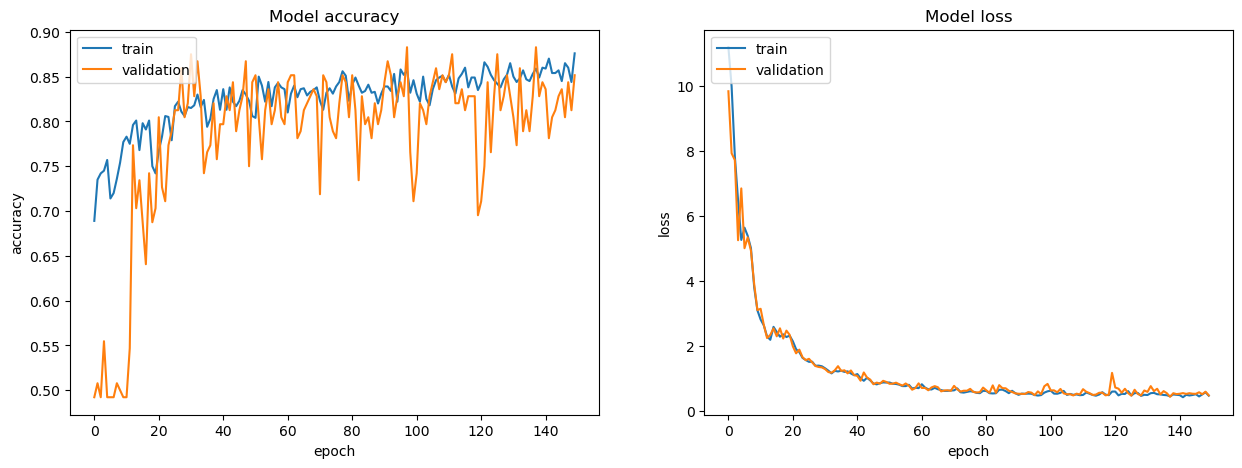

In [17]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_train_history(history)

In [18]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model
loaded_model=load_model("D:/Project/ML/glaucoma_detection3.h5")
print("Glaucoma Detection Model Loaded")
def glaucoma_prediction(test_image_path):
    test_image = image.load_img(test_image_path, target_size=(256, 256))
    test_image = img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)

    predictions = loaded_model.predict(test_image)

    result = {'class_0_probability': predictions[0][0], 'class_1_probability': predictions[0][1]}
    
#     predicted_class = np.argmax(predictions)
#     result['predicted_class'] = predicted_class

    return result

Glaucoma Detection Model Loaded


In [19]:
test_img_g="D:/Project/Datasets/Glaucoma-detection/Glaucoma Classification Datasets/glaucoma_combined/test/Glaucoma/Im409_g_ACRIMA.jpg"
prediction_g=glaucoma_prediction(test_img_g)
print(prediction_g)

1/1 [==============================] - 1s 1s/step
{'class_0_probability': 1.0, 'class_1_probability': 0.0}


In [20]:
test_img_n="D:/Project/Datasets/Glaucoma-detection/Glaucoma Classification Datasets/glaucoma_combined/test/Normal/Im014_ACRIMA.jpg"
prediction_n=glaucoma_prediction(test_img_n)
print(prediction_n)

1/1 [==============================] - 0s 76ms/step
{'class_0_probability': 1.0, 'class_1_probability': 0.0}


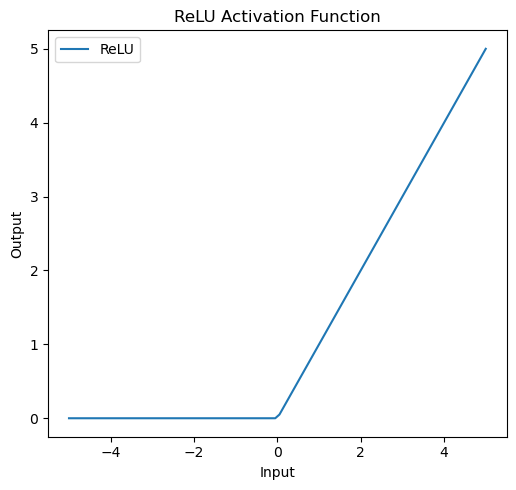

In [21]:
def relu(x):
    return np.maximum(0, x)

x_values = np.linspace(-5, 5, 100)

relu_values = relu(x_values)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(x_values, relu_values, label='ReLU')
plt.title('ReLU Activation Function')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
evaluation = model.evaluate(test_generator)
accuracy = evaluation[1]
print(f"Validation Accuracy: {accuracy}")

5/5 [==============================] - 5s 889ms/step - loss: 0.5616 - accuracy: 0.7786
Validation Accuracy: 0.7786259651184082


5/5 [==============================] - 4s 705ms/step


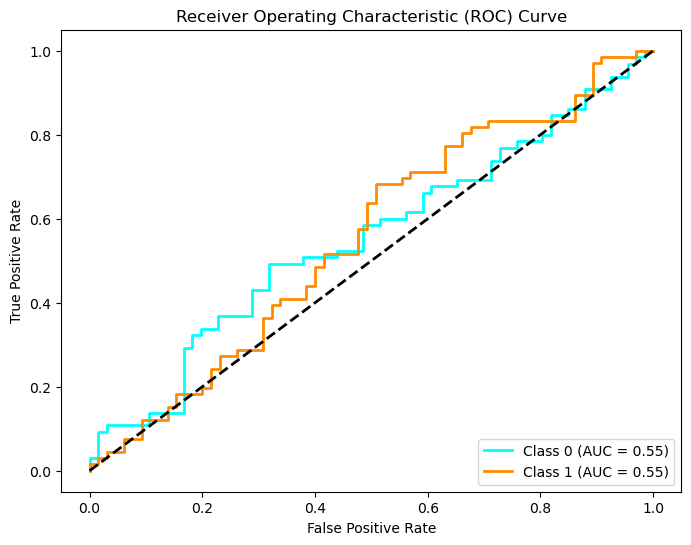

In [23]:
y_prob = loaded_model.predict(test_generator)
y_true = test_generator.classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(test_generator.num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(8, 6))

colors = cycle(['aqua', 'darkorange'])  
for i, color in zip(range(test_generator.num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()